In [1]:
import numpy as np
import scipy

import cupy as cp
import cupyx.scipy

import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output, display, HTML
display(HTML("<style>.container { width:90% !important; }</style>")) # just making the notebook cells wider
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))

from importlib import reload
import time

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

poppy_log.disabled = True

import warnings
warnings.filterwarnings("ignore")

import cgi_phasec_poppy

import ray
if not ray.is_initialized():
    ray.init(log_to_driver=False)
    
from math_module import xp, ensure_np_array
import efc_2dm 
import utils
from imshows import *

data_dir = efc_2dm.iefc_data_dir
response_dir = data_dir/'response-data'


INFO:numexpr.utils:Note: NumExpr detected 64 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


2023-10-13 08:23:38,891	INFO worker.py:1636 -- Started a local Ray instance.


0.1 0.0072010264910560605 arcsec / pix


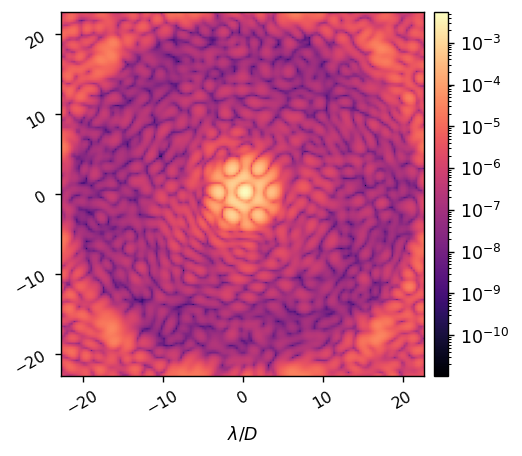

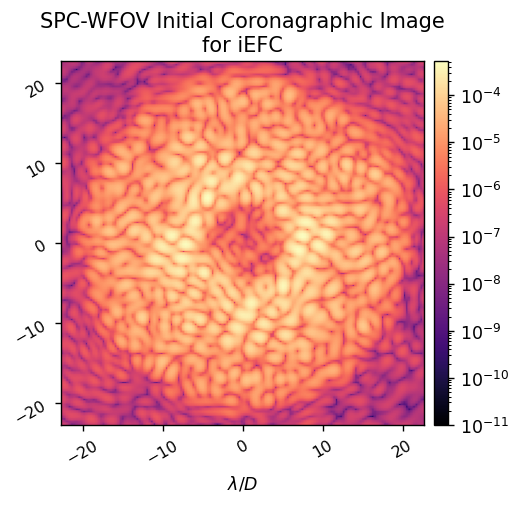

In [2]:
reload(cgi_phasec_poppy.cgi)
mode = cgi_phasec_poppy.cgi.CGI(cgi_mode='spc-wide', npsf=150,
                                  use_pupil_defocus=True, 
                                  use_opds=True)
# mode.det_rotation = 1
mode.use_fpm = False
ref_unocc_im = mode.snap()
imshow1(ref_unocc_im, pxscl=mode.psf_pixelscale_lamD, xlabel='$\lambda/D$', lognorm=True)

mode.Imax_ref = ref_unocc_im.get().max()
mode.use_fpm = True

ref_im = mode.snap()
imshow1(ref_im, 'SPC-WFOV Initial Coronagraphic Image\nfor iEFC',
        pxscl=mode.psf_pixelscale_lamD, xlabel='$\lambda/D$', lognorm=True, vmin=1e-11)

# Create dark hole ROI to calibrate and control

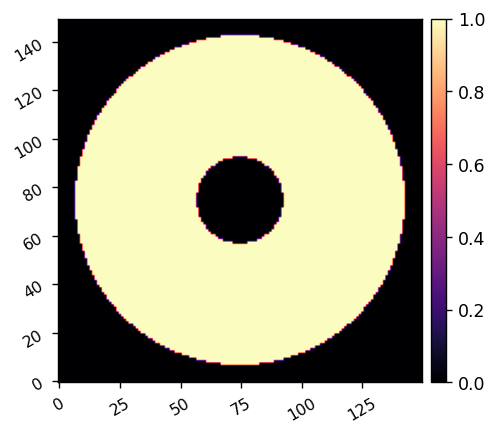

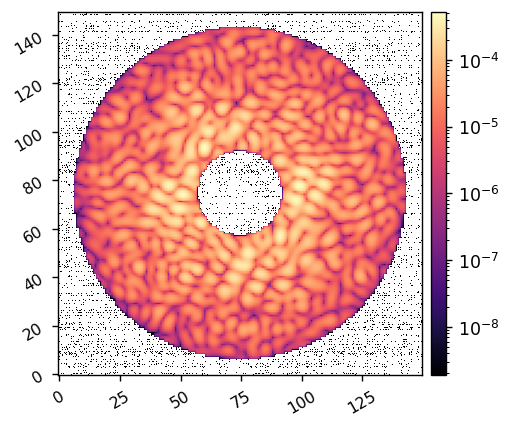

3.042688486608366e-05


In [3]:
reload(utils)
control_mask = utils.create_annular_focal_plane_mask(mode, inner_radius=5.4, outer_radius=20.6, edge=None, plot=True)

imshow1(control_mask*ref_im, lognorm=True)
mean_ni = xp.mean(ref_im[control_mask])
print(mean_ni)

# Create calibration modes


(3608, 4608)


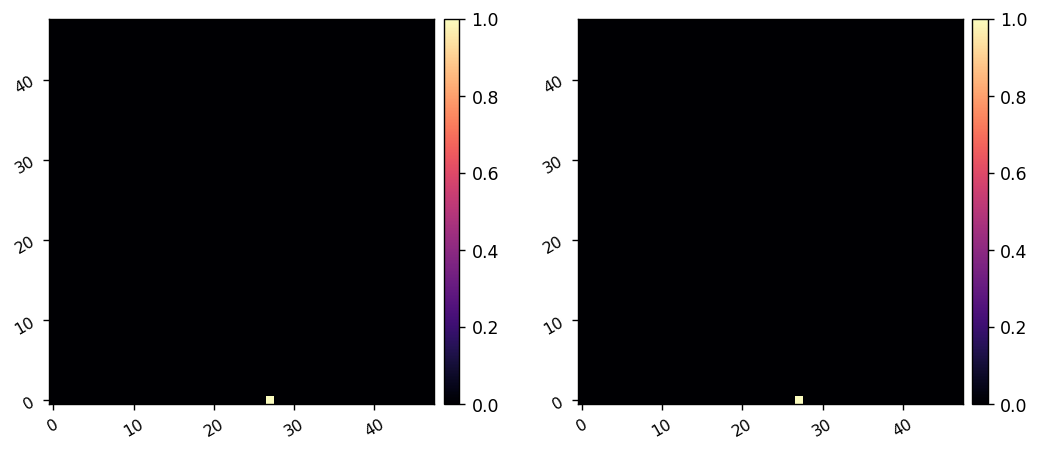

In [4]:
calib_modes = utils.create_all_poke_modes(mode.dm_mask, ndms=2)
Nmodes = calib_modes.shape[0]
print(calib_modes.shape)
i = 8
imshow2(calib_modes[i,:mode.Nact**2].reshape(mode.Nact,mode.Nact), calib_modes[i+mode.Nacts,mode.Nact**2:].reshape(mode.Nact,mode.Nact))


Calculating Jacobian: 
	Calculated response for mode 3608/3608. Elapsed time=2100.461 sec.
Jacobian built in 2100.461 sec


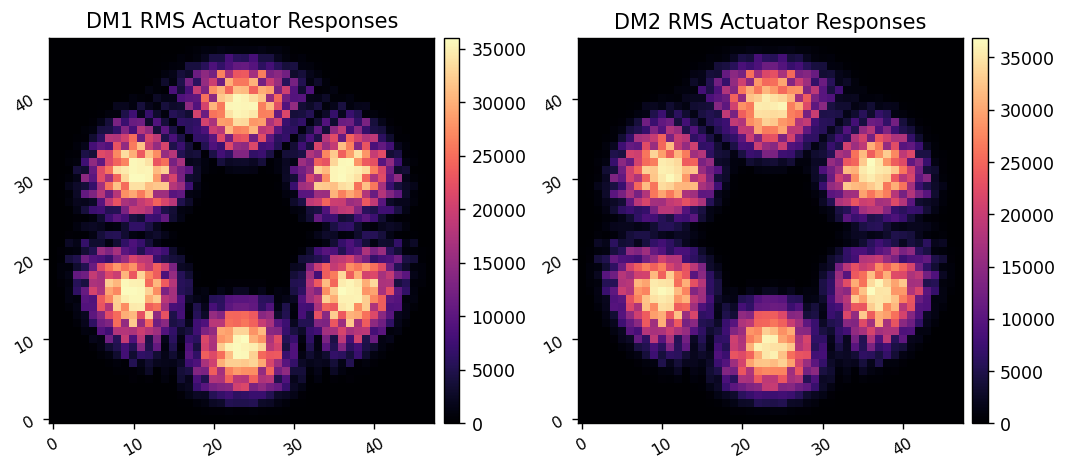

In [5]:
reload(efc_2dm)

calib_amp = 1e-9

jac = efc_2dm.build_jacobian(mode, calib_amp, calib_modes, control_mask,
                             plot_responses=True,
                            )

# utils.save_fits(response_dir/f'test_response_matrix_{today}.fits', response_matrix)
# utils.save_fits(response_dir/f'test_response_cube_{today}.fits', response_cube)


In [6]:
utils.save_fits(response_dir/f'efc_jacobian_{20231013}.fits', jac)

Saved data to:  /home/kianmilani/Projects/roman-cgi-iefc-data/response-data/efc_jacobian_20231013.fits


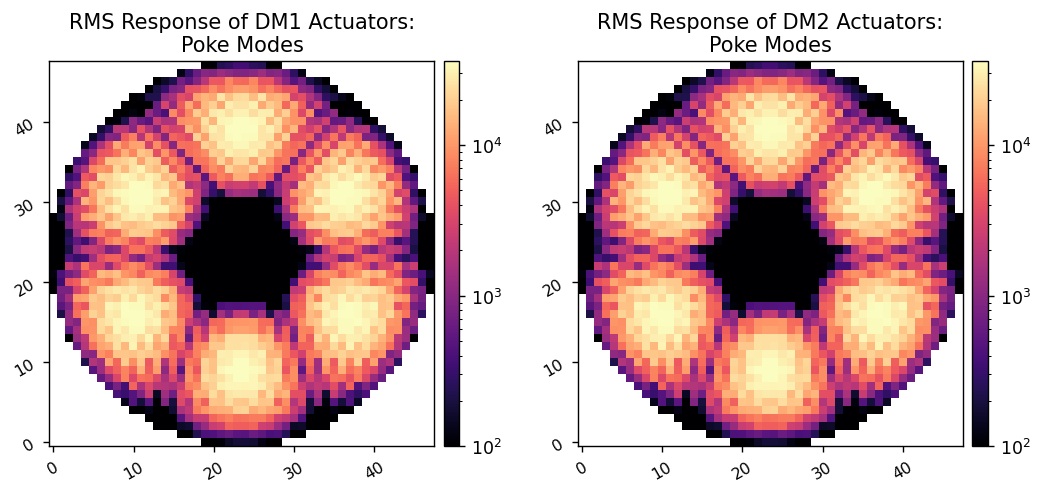

In [7]:
# date = 20231008
date = 20231013
response_matrix = xp.array(fits.getdata(response_dir/f'efc_jacobian_{date}.fits'))

# date= 20231009
# response_matrix = xp.array(fits.getdata(response_dir/f'efc_jacobian_hadamard_{date}.fits'))

responses = response_matrix[::2] + 1j*response_matrix[1::2]

dm_response = xp.sqrt(xp.mean(xp.abs(responses.dot(xp.array(calib_modes)))**2, axis=0))
dm1_response = dm_response[:mode.Nact**2].reshape(mode.Nact, mode.Nact)
dm2_response = dm_response[:mode.Nact**2].reshape(mode.Nact, mode.Nact)
imshow2(dm1_response, dm2_response, 
        'RMS Response of DM1 Actuators:\nPoke Modes', 'RMS Response of DM2 Actuators:\nPoke Modes',
        lognorm=True, vmin1=1e2, vmin2=1e2,
        )


# Run EFC

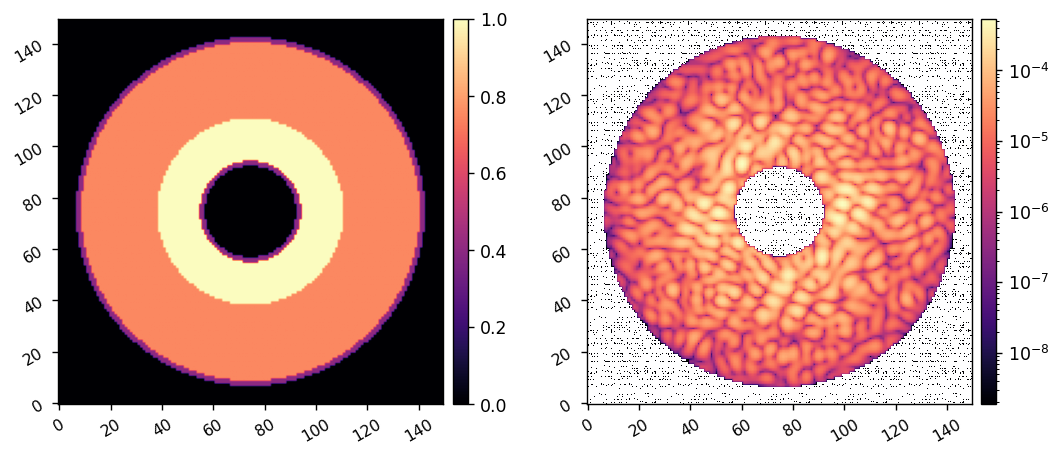

3.042688486608366e-05


In [10]:
reload(utils)
roi1 = utils.create_annular_focal_plane_mask(mode, inner_radius=6, outer_radius=20, edge=None)
roi2 = utils.create_annular_focal_plane_mask(mode, inner_radius=5.4, outer_radius=20.6, edge=None)
roi3 = utils.create_annular_focal_plane_mask(mode, inner_radius=6, outer_radius=11, edge=None)

relative_weight_1 = 0.75
relative_weight_2 = 0.4
weight_map = roi3 + relative_weight_1*(roi1*~roi3) + relative_weight_2*(roi2*~roi1*~roi3)
control_mask = weight_map>0
imshow2(weight_map, control_mask*ref_im, lognorm2=True)
mean_ni = xp.mean(ref_im[control_mask])
print(mean_ni)

In [11]:
mode.reset_dms()

images = xp.array([ref_im])
dm1_commands = xp.array([mode.get_dm1()])
dm2_commands = xp.array([mode.get_dm2()])

In [33]:
mode.set_dm1(ensure_np_array(dm1_commands[-8]))
mode.set_dm2(ensure_np_array(dm2_commands[-8]))

In [27]:
reload(utils)
reg_cond = 1e-2
# reg_cond = 1e-3
control_matrix = utils.WeightedLeastSquares(response_matrix, rcond=reg_cond, weight_map=weight_map, algorithm='efc')
# control_matrix = utils.TikhonovInverse(response_matrix, reg_cond)
# probe_amp = 2e-8

control_matrix.shape


(3608, 27048)

In [18]:
import imshows
reload(imshows)

<module 'imshows' from '/home/kianmilani/Projects/roman-cgi-iefc/imshows.py'>

Beginning closed-loop EFC simulation.
Max singular value squared:	 80905570708438.03
alpha^2:			 18338203776255.785
	Running iteration 36/40.


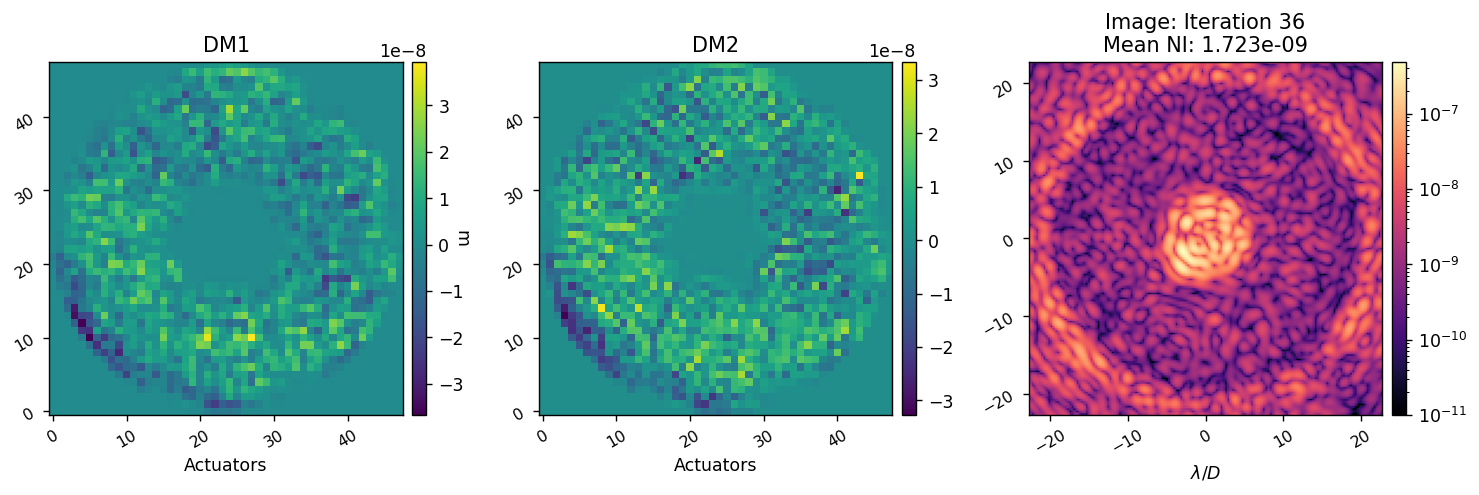

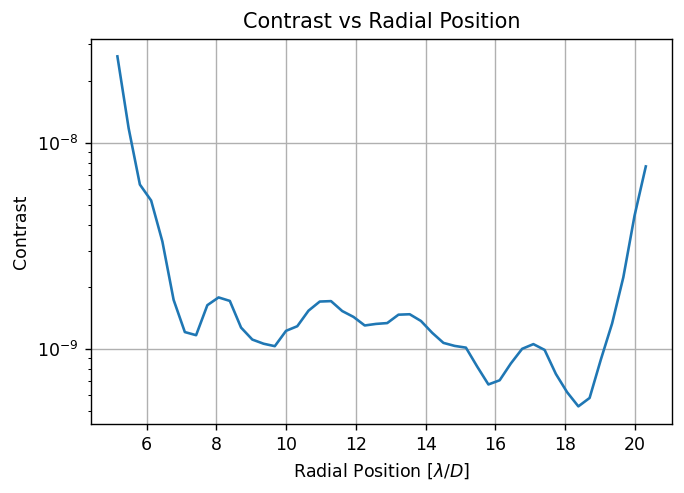

	Running iteration 37/40.


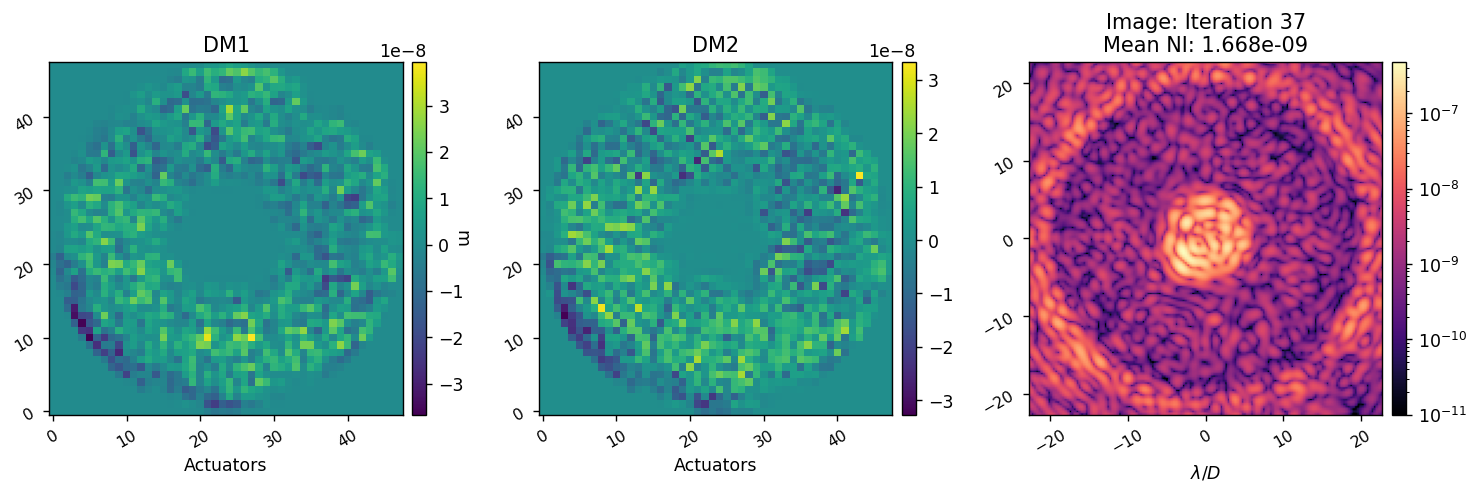

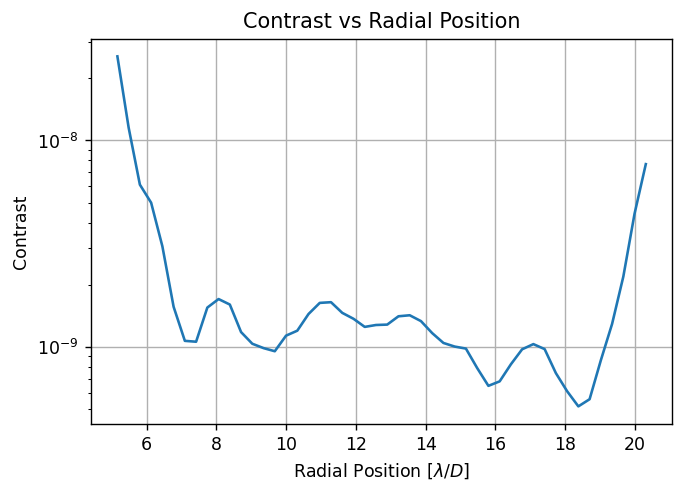

	Running iteration 38/40.


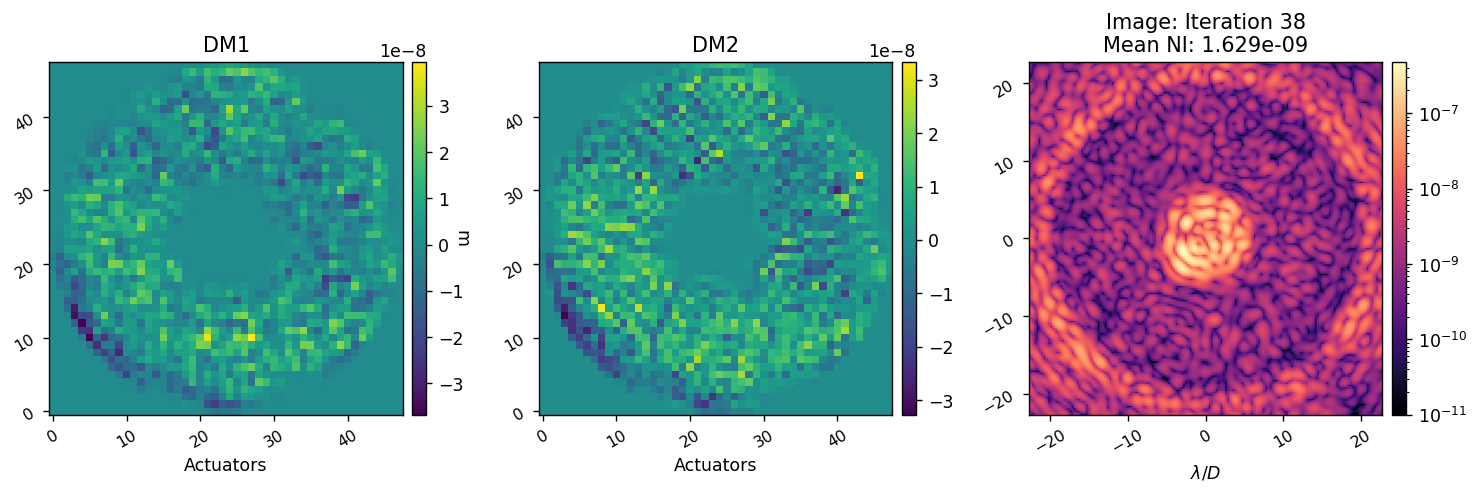

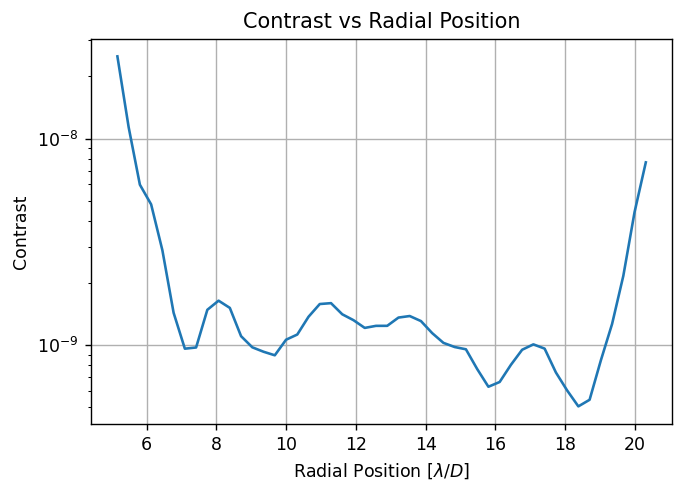

	Running iteration 39/40.


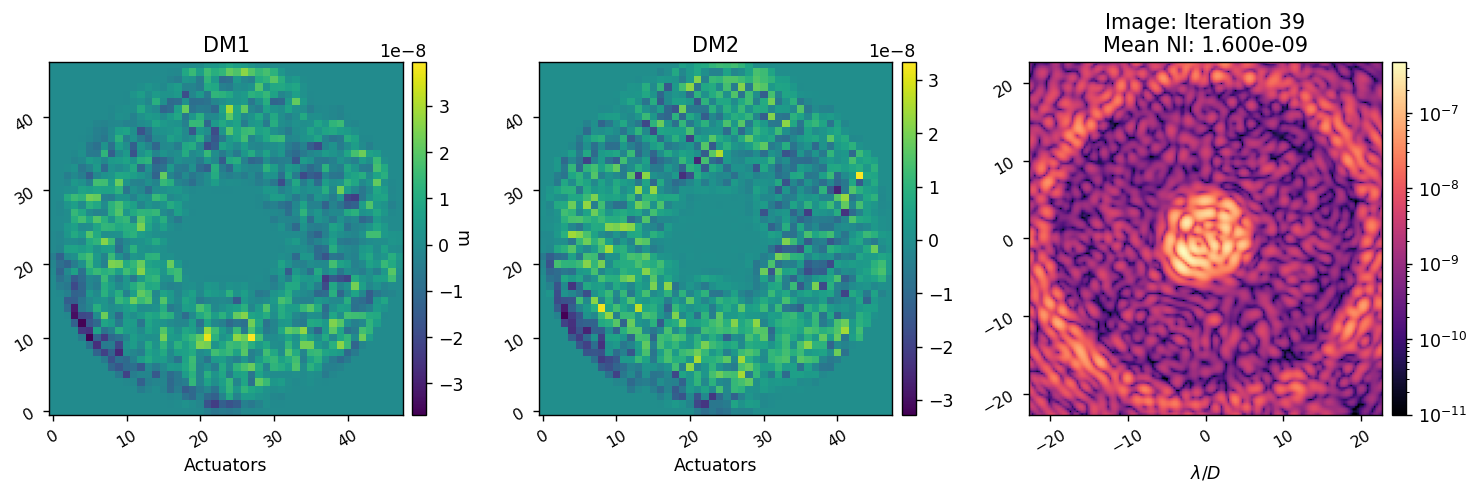

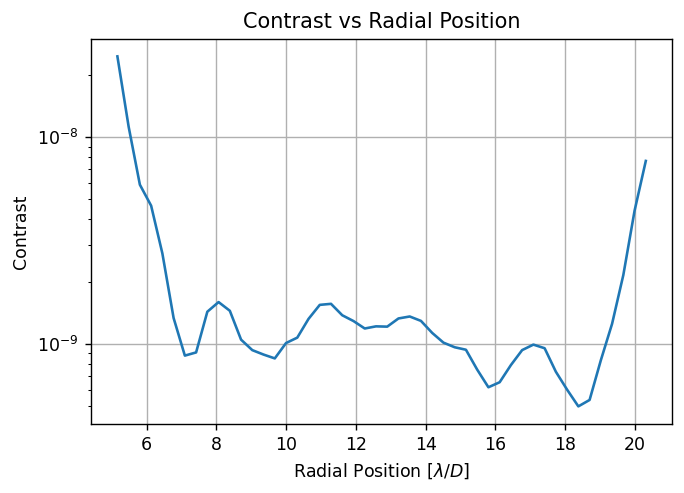

	Running iteration 40/40.


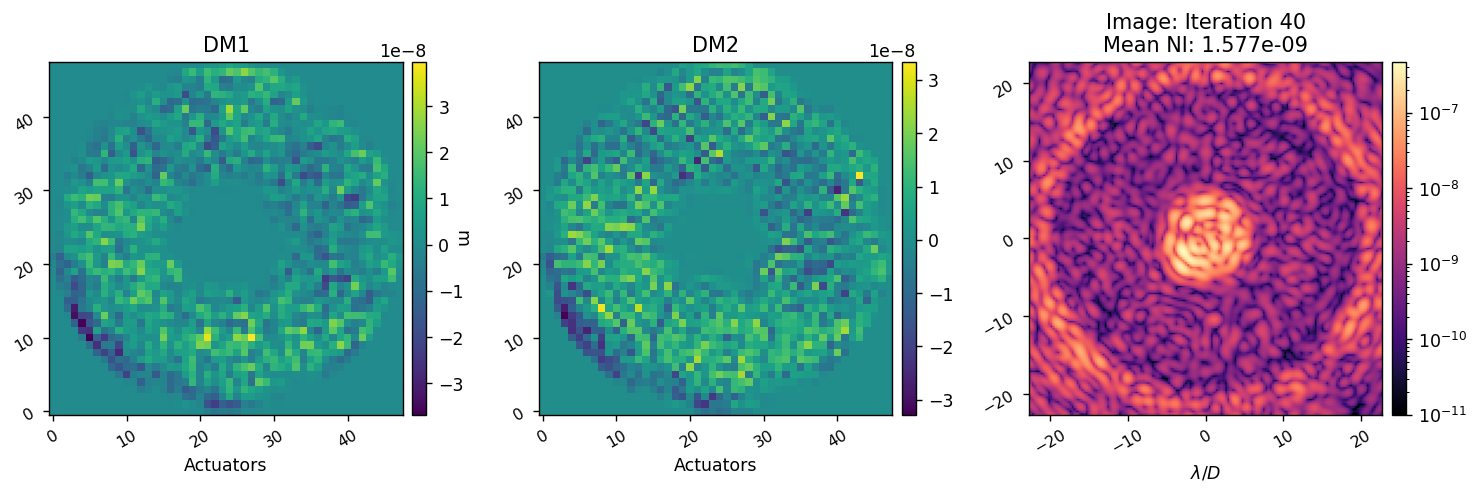

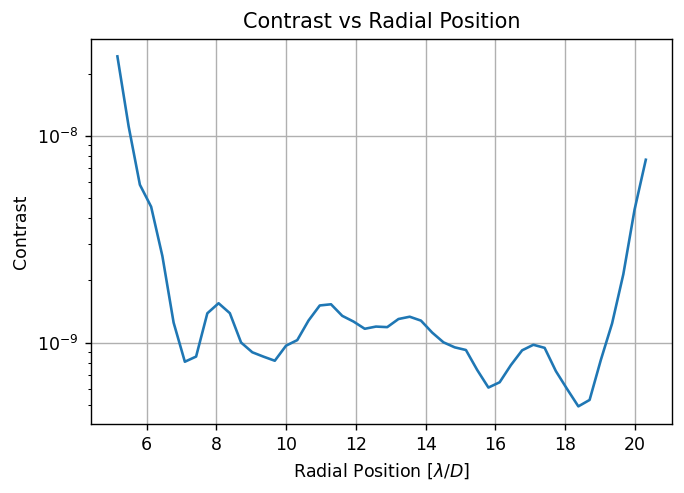

EFC completed in 9.613 sec.


In [28]:
reload(efc_2dm)

images, dm1_commands, dm2_commands = efc_2dm.run_efc_perfect(mode, 
                    response_matrix, 
                    calib_modes,
                    control_matrix,
                    control_mask, 
                    Imax_unocc=1,
                    loop_gain=0.5, 
                    leakage=0.0,
                    iterations=5, 
                    plot_all=True, 
                    plot_sms=False,
                    plot_radial_contrast=True,
                    old_images=images,
                    old_dm1_commands=dm1_commands,
                    old_dm2_commands=dm2_commands,
                    )


In [29]:
date

20231013

In [30]:
utils.save_fits(response_dir/f'spc_wfov_825_efc_hadamard_dm1_commands_{date}.fits', dm1_commands)
utils.save_fits(response_dir/f'spc_wfov_825_efc_hadamard_dm2_commands_{date}.fits', dm2_commands)
utils.save_fits(response_dir/f'spc_wfov_825_efc_hadamard_images_{date}.fits', images)

Saved data to:  /home/kianmilani/Projects/roman-cgi-iefc-data/response-data/spc_wfov_825_efc_hadamard_dm1_commands_20231013.fits
Saved data to:  /home/kianmilani/Projects/roman-cgi-iefc-data/response-data/spc_wfov_825_efc_hadamard_dm2_commands_20231013.fits
Saved data to:  /home/kianmilani/Projects/roman-cgi-iefc-data/response-data/spc_wfov_825_efc_hadamard_images_20231013.fits


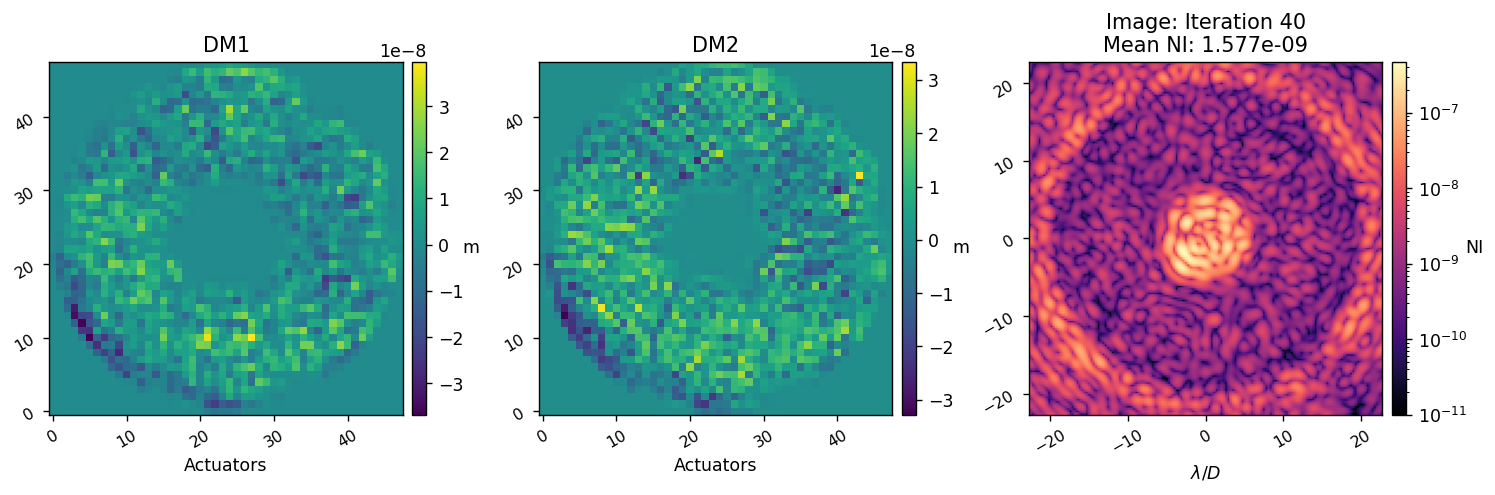

In [34]:
reload(imshows)
from imshows import *
itr = 40
mean_ni = xp.mean(images[itr][control_mask])

imshow3(dm1_commands[itr], dm2_commands[itr], images[itr], 
        'DM1', 'DM2', f'Image: Iteration {itr}\nMean NI: {mean_ni:.3e}',
        cmap1='viridis', cmap2='viridis',
        cbar1_label='m', cbar2_label='m', cbar3_label='NI',
        xlabel1='Actuators', xlabel2='Actuators',
            lognorm3=True, vmin3=1e-11, pxscl3=mode.psf_pixelscale_lamD, xlabel3='$\lambda/D$')